<a href="https://colab.research.google.com/github/jorgealarconlucas/TFG/blob/master/Modelos_de_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
x_train = pd.read_feather('x_train')
y_train = np.load ('y_train.npy')
x_test = pd.read_feather('x_test')
y_test = np.load ('y_test.npy')

In [3]:
y_train = pd.Series(y_train) #Lo paso de numpy a pandas.series
y_test = pd.Series(y_test)

# Machine learning para revision = 1

### Con X_train

In [4]:
x_train_1 = x_train[x_train['Revision'] == 1]

x_train_1.head()

,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,...,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,Revision
1,76.0,0.0,3.75,1.840,49.00,1.290,34.40,0.490,13.10,0.110,...,3.75,0.00,0.000,17.1,5.90,0.22,146.60,53.80,0.00,1.0
5,66.0,0.0,3.05,1.170,38.50,1.050,34.40,0.800,8.84,0.010,...,3.05,0.00,0.000,7.6,2.60,0.08,151.00,56.50,0.00,1.0
16,37.0,0.0,9.64,5.416,53.06,3.348,37.26,0.692,7.92,0.064,...,9.64,0.14,0.004,8.6,2.54,0.20,147.86,49.04,0.34,1.0
19,85.0,1.0,17.25,15.160,87.90,0.980,5.70,0.880,5.10,0.050,...,17.25,0.00,0.000,11.2,0.60,0.11,155.30,48.60,0.00,1.0
22,74.0,0.0,4.89,3.570,72.90,0.610,12.50,0.350,7.20,0.010,...,4.89,0.00,0.000,23.0,2.90,0.14,148.70,52.10,0.00,1.0


In [5]:
#Elimino la variable 'Revision' puesto que una vez he cogido los pacientes con revision=1, la variable ya 
#no me hace falta.
x_train_1 = x_train_1.drop(["Revision"],axis=1) 

In [6]:
len(y_train)

#get a boolean np.array as index
idx = x_train['Revision'] == 1

idx = idx.values

y_train_aux = y_train.values

y_train_1 = y_train_aux[idx]

print(y_train_1)

[0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0]


### Con X_test

CREO QUE EN X_TEST NO HAY QUE TOCAR NADA. POR TANTO ESTO HABRIA QUE BORRARLO.

In [7]:
x_test_1 = x_test[x_test['Revision'] == 1]

x_test_1.head()

,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,...,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,Revision
2,76.0,0.0,8.060,5.980,74.30,1.210,15.00,0.690,8.60,0.140,...,8.060,0.00,0.000,6.60,1.0,0.080,159.30,49.60,0.00,1.0
3,72.0,1.0,6.794,5.332,74.16,0.802,14.42,0.400,6.16,0.058,...,6.794,0.14,0.006,14.00,1.2,0.068,149.08,53.14,2.86,1.0
6,69.0,0.0,11.886,17.120,65.20,2.550,9.70,0.606,18.20,0.010,...,11.886,0.40,0.100,9.40,0.9,0.240,136.80,48.56,3.90,1.0
7,72.0,1.0,6.850,4.670,68.10,1.520,22.20,0.500,7.30,0.080,...,6.850,0.00,0.000,13.80,3.1,0.210,141.40,47.90,0.00,1.0
15,83.0,1.0,9.122,7.002,71.80,0.994,14.10,0.768,8.96,0.104,...,9.122,0.00,0.014,9.72,2.0,0.120,152.00,50.18,0.98,1.0


In [8]:
#Elimino la variable 'Revision' puesto que una vez he cogido los pacientes con revision=1, la variable ya 
#no me hace falta.
x_test_1 = x_test_1.drop(["Revision"],axis=1)  

In [9]:
len(y_test)

#get a boolean np.array as index
idx = x_test['Revision'] == 1

idx = idx.values

y_test_aux = y_test.values

y_test_1 = y_test_aux[idx]

print(y_test_1) #Misma cantidad de números que la cantidad de filas de x_test_1

[0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0]


# 1. XGBoost

In [10]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb

## 1.1 Optimización de los hiperparámetros usando RandomizedSearchCV

In [11]:
#Indico que el clasificador que voy a utlizar es XGBosst

xgb_model = xgb.XGBClassifier(
)

Inicialmente creamos un diccionario de algunos parámetros a entrenar. Aquí las claves son básicamente los parámetros y los valores a entrenar. Así que el RandomizedSearchCV probará cada valor y encontrará el valor particular que da la mayor precisión.

In [12]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [25,50,75,100,125,150,175,200,250,300,350,400],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [3,4,5,6,8,10,12,15],
 'gamma': [0.0,0.1,0.2,0.3,0.4],
 'colsample_bytree' : [0.3,0.4,0.5,0.7]
}



A continuación, llamamos a RandomizedSearchCV() y le pasamos los siguientes parámetros

In [13]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model = RandomizedSearchCV(xgb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 250,
                                                         300, 350, 400]},
                   random_state=2, scoring='roc_auc', verbose=3)

Bien, nuestro modelo ha sido ajustado. Veamos ahora todos los parámetros que han sido seleccionados por el RandomizedSearch() para el XGBClassifier. Podemos hacerlo con la ayuda del método best_estimators_.

In [14]:
r_s_model.best_estimator_

XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=4,
              n_estimators=50)

Una vez conozco los valores de hiperparámetros, vuelvo a buscar la optimización de los mismos, pero esta vez afinando más.

In [15]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [192,194,196,198,200,202,204,206,208],
 'learning_rate' : [0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19],
 'max_depth' : [8,9,10,11,12,13,14,15,16],
 'gamma': [0.30,0.33,0.36,0.39,0.42,0.45,0.48],
 'colsample_bytree' : [0.15,0.20,0.25,0.30,0.35,0.40,0.45]
}

In [16]:
print(x_train_1.columns)
print(y_train_1)
#print(x_test_1['Revision'].head())

Index(['Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NESFL', 'NESSC', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL'],
      dtype='object')
[0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0]


In [17]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model = RandomizedSearchCV(xgb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.15, 0.2, 0.25,
                                                             0.3, 0.35, 0.4,
                                                             0.45],
                                        'gamma': [0.3, 0.33, 0.36, 0.39, 0.42,
                                                  0.45, 0.48],
                                        'learning_rate': [0.11, 0.12, 0.13,
                                                          0.14, 0.15, 0.16,
                                                          0.17, 0.18, 0.19],
                                        'max_depth': [8, 9, 10, 11, 12, 13, 14,
                                                      15, 16],
                                        'n_estimators': [192, 194, 196, 198,
                                                         200, 202, 204, 206,
                                    

In [18]:
r_s_model.best_estimator_

XGBClassifier(colsample_bytree=0.45, gamma=0.48, learning_rate=0.15,
              max_depth=11, n_estimators=192)

## 1.2 Rendimiento con todas las features

Ahora, como conocemos todos los mejores parámetros, podemos simplemente construir nuestro modelo clasificador final pasando todos esos parámetros.

In [19]:
#Construyendo el modelo final
xgb_model = xgb.XGBClassifier(colsample_bytree=0.45, gamma=0.3, learning_rate=0.15,
              max_depth=16, n_estimators=202)

In [20]:
#print(x_test['Fecha'])

In [21]:
x_test_WR = x_test.drop(["Revision"],axis=1)

In [22]:
#Métricas

xgb_model.fit(x_train_1, y_train_1)

y_pred = xgb_model.predict(x_test_WR)

acc_xgb = accuracy_score(y_test, y_pred)
sensibilidad_xgb = recall_score(y_test, y_pred)
#precision_xgb = precision_score(y_test, y_pred)
specificity_xgb = confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1])
auc_xgb = roc_auc_score(y_test, y_pred)

Tabla = pd.DataFrame({ "Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                      "XGBoost" : [acc_xgb, sensibilidad_xgb, specificity_xgb, auc_xgb]})

Tabla

,Prestaciones en test,XGBoost
0,Accuracy,0.781250
1,Sensibility,0.250000
2,Specificity,0.903846
3,AUC ROC,0.576923


## 1.3 Selección de características (FS)

La selección de características se entiende como una disminución del número de éstas, en función de un criterio elegido por el usuario, escogiendo aquellas que se consideran más informativas y eliminando aquellas que son irrelevantes. 

**Importancia de cada característica**

La importancia de características desempeña un papel importante, ya que proporciona una visión de los datos, del modelo y la base para la reducción de la dimensionalidad y la selección de características que pueden mejorar la eficiencia y la eficacia de un modelo predictivo en el problema.

Para tener mas aleatoridad a la hora de valorar la importancia de las características sobre las que trabajo, voy a hacer:

1.   Con ese conjunto hago "permutation importance"



### Permutation Importance

Este método consiste en ir barajando columna a columna (excepto el target) y ver como va variando la predicción respecto a la salida real. De esa manera se puede observar que columnas tienen mas importancia que otras. 

In [23]:
x_test_1.shape

(22, 66)

In [24]:
x_test_1.head()

,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,...,WBC-D,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL
2,76.0,0.0,8.060,5.980,74.30,1.210,15.00,0.690,8.60,0.140,...,8.000,8.060,0.00,0.000,6.60,1.0,0.080,159.30,49.60,0.00
3,72.0,1.0,6.794,5.332,74.16,0.802,14.42,0.400,6.16,0.058,...,6.826,6.794,0.14,0.006,14.00,1.2,0.068,149.08,53.14,2.86
6,69.0,0.0,11.886,17.120,65.20,2.550,9.70,0.606,18.20,0.010,...,11.630,11.886,0.40,0.100,9.40,0.9,0.240,136.80,48.56,3.90
7,72.0,1.0,6.850,4.670,68.10,1.520,22.20,0.500,7.30,0.080,...,6.860,6.850,0.00,0.000,13.80,3.1,0.210,141.40,47.90,0.00
15,83.0,1.0,9.122,7.002,71.80,0.994,14.10,0.768,8.96,0.104,...,9.122,9.122,0.00,0.014,9.72,2.0,0.120,152.00,50.18,0.98


In [25]:
#XGB = x_test.sample(n=40, replace=True, random_state=1)

In [26]:
#x_test.head

In [27]:
#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.625, random_state=1) #40 de 64 es el 0.625%
#sss.split(x_test,y_test)

In [28]:
#Oscar: we are going to call validation the new subset from X and y test

#for train_index, test_index in sss.split(x_test, y_test):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    __, X_val = x_test.loc[train_index], x_test.loc[test_index]
#    __, y_val = y_test[train_index], y_test[test_index]

In [29]:
#X_val['Revision']

In [30]:
%%capture
!pip install eli5

In [31]:
%%capture
!pip install category_encoders

In [32]:
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [33]:
perm = PermutationImportance(xgb_model, random_state=1).fit(x_test_WR, y_test)
eli5.show_weights(perm, feature_names = x_test_WR.columns.tolist())

Weight,Feature
0.0250 ± 0.0153,MicR
0.0125 ± 0.0125,NESFL
0.0125 ± 0.0125,IG
0.0063 ± 0.0153,HGB
0.0063 ± 0.0153,IGp
0.0063 ± 0.0319,LINp
0.0063 ± 0.0153,HCM
0.0063 ± 0.0424,MO-Y
0.0031 ± 0.0125,LY-Y
0.0031 ± 0.0125,RELPL


### OSCAR

In [34]:
"""
def permutation (x_train, y_train, x_test, y_test):
  encoder = ce.OneHotEncoder(use_cat_names=True)

  x_train_s = encoder.fit_transform(x_train_1)
  x_test_s = encoder.transform(x_test_WR)

  #Fitting the model.
  model = xgb.XGBClassifier(random_state=42)
  model.fit(x_train_s, y_train_1)

  permuter = PermutationImportance(
      estimator = model,
      scoring = 'r2',
      n_iter = 5,
      random_state = 42)
  
  permuter.fit(x_test_s, y_test)

  columns = x_test_s.columns.to_list()

  feature_importance = permuter.feature_importances_

  pd.Series(feature_importance, columns).sort_values(ascending=False)

  metric = eli5.show_weights(
      estimator = permuter,
      top = None,
      feature_names = columns)
  
  return metric
"""

"\ndef permutation (x_train, y_train, x_test, y_test):\n  encoder = ce.OneHotEncoder(use_cat_names=True)\n\n  x_train_s = encoder.fit_transform(x_train_1)\n  x_test_s = encoder.transform(x_test_WR)\n\n  #Fitting the model.\n  model = xgb.XGBClassifier(random_state=42)\n  model.fit(x_train_s, y_train_1)\n\n  permuter = PermutationImportance(\n      estimator = model,\n      scoring = 'r2',\n      n_iter = 5,\n      random_state = 42)\n  \n  permuter.fit(x_test_s, y_test)\n\n  columns = x_test_s.columns.to_list()\n\n  feature_importance = permuter.feature_importances_\n\n  pd.Series(feature_importance, columns).sort_values(ascending=False)\n\n  metric = eli5.show_weights(\n      estimator = permuter,\n      top = None,\n      feature_names = columns)\n  \n  return metric\n"

In [35]:
#permutation(x_train_1, y_train_1, x_test_WR, y_test) #si pongo x_train, y_train, x_test e y_test funciona ¿?¿?¿?

### HASTA AQUI

1.0


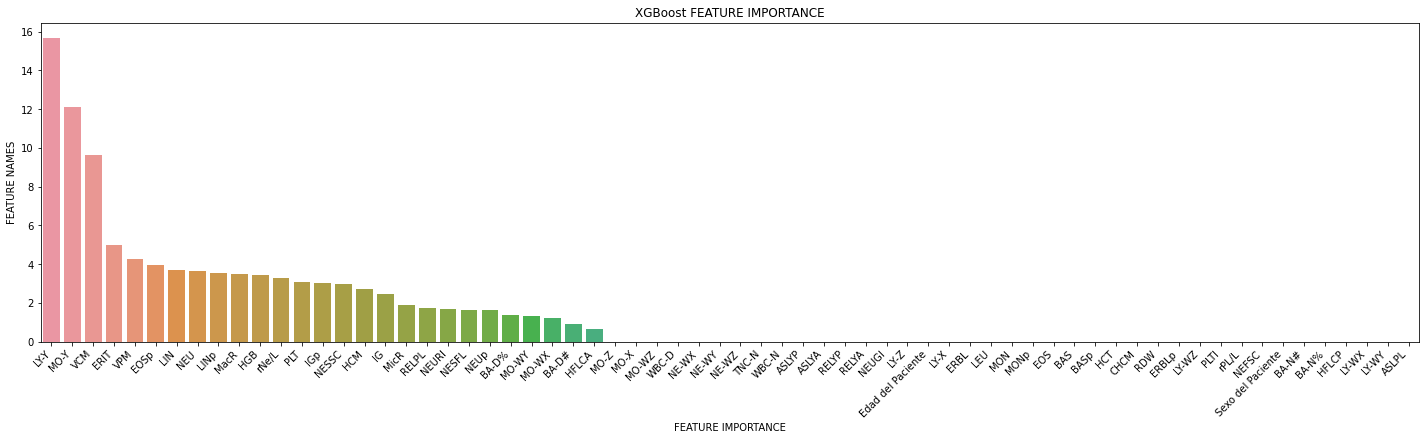

In [36]:
import seaborn as sns
#Plot feature importance
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  fig = plt.figure(figsize=(20,6))
  #Plot Searborn bar chart
  sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  plt.tight_layout()
  fig.autofmt_xdate(rotation=45)


plot_feature_importance(xgb_model.feature_importances_*100,x_train_1.columns,'XGBoost ')

print(np.sum(xgb_model.feature_importances_))

A partir de este gráfico se puede observar la importancia de cada característica haciendo uso de XGBoost. Así pues, VCM es la variable que aporta mayor información al realizar la tarea de clasificación, con lo que permitirá, en mayor medida, diferenciar un paciente sano de uno no sano. No obstante, las 3  variables siguientes MO-Y, MacR y IG también presentan información relevante para la predicción.

**Selección de las características en base a la importancia de éstas**

In [37]:
"""
#SelectFromModel

scores_cv = []
thresholds = np.sort(xgb_model.feature_importances_) # obtiene la importancia de cada característica
i = 0
for thresh in thresholds:
    print("{} de {}".format(i,len(thresholds)))
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_x_train_1 = selection.transform(x_train_1)
    # train model
    selection_model = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, use_label_encoder = False)
    #cv estimation
    sc =cross_val_score(selection_model, select_x_train_1, y_train_1, cv=10, scoring='roc_auc',n_jobs=-1)
    scores_cv.append(sc)
    i+=1

"""

'\n#SelectFromModel\n\nscores_cv = []\nthresholds = np.sort(xgb_model.feature_importances_) # obtiene la importancia de cada característica\ni = 0\nfor thresh in thresholds:\n    print("{} de {}".format(i,len(thresholds)))\n    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)\n    select_x_train_1 = selection.transform(x_train_1)\n    # train model\n    selection_model = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, use_label_encoder = False)\n    #cv estimation\n    sc =cross_val_score(selection_model, select_x_train_1, y_train_1, cv=10, scoring=\'roc_auc\',n_jobs=-1)\n    scores_cv.append(sc)\n    i+=1\n\n'

In [38]:
"""
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize = (80,20))
sc_cv = np.asarray(scores_cv)
scores_m = np.mean(sc_cv,axis = 1)
scores_std = np.std(sc_cv,axis = 1)
xx = np.arange(len(scores_m))
plt.plot(xx,scores_m,'o-')
plt.grid()
_ = plt.xticks(xx,labels= np.arange(1,len(scores_m)+1))
plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
"""

"\nplt.rc('xtick',labelsize=15)\nplt.rc('ytick',labelsize=15)\nplt.figure(figsize = (80,20))\nsc_cv = np.asarray(scores_cv)\nscores_m = np.mean(sc_cv,axis = 1)\nscores_std = np.std(sc_cv,axis = 1)\nxx = np.arange(len(scores_m))\nplt.plot(xx,scores_m,'o-')\nplt.grid()\n_ = plt.xticks(xx,labels= np.arange(1,len(scores_m)+1))\nplt.xlabel('Number of features removed')\nplt.ylabel('Accuracy')\nplt.ylim([0.5,1])\n"

Esta gráfica muestra el ***accuracy*** que se alcanza cuando se escogen X características. Desde la izquierda hacia la derecha se van quitando variables consecutivamente, y se puede observar que la predicción del modelo no se degrada hasta llegar a 67 variables. Es decir, solo quedándonos con 4  variables, el modelo es capaz de tener el mismo desempeño en predicción que utilizando todas las variables. Estas característica son las 4 primeras representadas anteriormente en la gráfica anterior.

Además siempre es preferible tener un modelo menos complejo para que de esta forma pueda haber una mejor generalizacion con la incorporación de datos nuevos.

## 1.4 Rendimiento con FS en el conjunto de test

In [39]:
"""
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

#convert into a dataframe with sorted feature importances
fi = rf_feat_importance(xgb_model,x_train_1)

#select the features
selected_features_RF = fi[:len(fi)-63]['cols'].to_list()
print("Numero de variables seleccionadas Pars:",len(selected_features_RF))
print("Selected features:",selected_features_RF)


X_train_FT_xgb = x_train_1[selected_features_RF]
X_test_FT_xgb = x_test[selected_features_RF]
"""

'\ndef rf_feat_importance(m, df):\n    return pd.DataFrame({\'cols\':df.columns, \'imp\':m.feature_importances_}\n                       ).sort_values(\'imp\', ascending=False)\n\n#convert into a dataframe with sorted feature importances\nfi = rf_feat_importance(xgb_model,x_train_1)\n\n#select the features\nselected_features_RF = fi[:len(fi)-63][\'cols\'].to_list()\nprint("Numero de variables seleccionadas Pars:",len(selected_features_RF))\nprint("Selected features:",selected_features_RF)\n\n\nX_train_FT_xgb = x_train_1[selected_features_RF]\nX_test_FT_xgb = x_test[selected_features_RF]\n'

Selecciono las características del método permutation importance haciendo uso de .loc

In [40]:
X_train_FT_xgb = x_train_1.loc[:,['MicR', 'LINp', 'HGB', 'HCM', 'NEUp', 'HFLCA', 'RELPL', 'ERIT', 'IGp']]
X_test_FT_xgb = x_test_WR.loc[:,['MicR', 'LINp', 'HGB', 'HCM', 'NEUp', 'HFLCA', 'RELPL', 'ERIT', 'IGp']]

In [41]:
xgb_FS = xgb.XGBClassifier(colsample_bytree=0.45, gamma=0.3, learning_rate=0.15,
              max_depth=16, n_estimators=202)
xgb_FS.fit(X_train_FT_xgb, y_train_1)

XGBClassifier(colsample_bytree=0.45, gamma=0.3, learning_rate=0.15,
              max_depth=16, n_estimators=202)

In [42]:
from sklearn.metrics import roc_auc_score

#Todas las características
y_pred_tot = xgb_model.predict(x_test_WR)
acc_tot = accuracy_score(y_test, y_pred_tot)
sensibilidad_tot = recall_score(y_test, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_test, y_pred_tot)[0][0]/(confusion_matrix(y_test, y_pred_tot)[0][0]+confusion_matrix(y_test, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_test, y_pred_tot)


#8 características 
y_pred_8 = xgb_FS.predict(X_test_FT_xgb)
acc_8 = accuracy_score(y_test, y_pred_8)
sensibilidad_8 = recall_score(y_test, y_pred_8)
#precision_8 = precision_score(y_test, y_pred_8)
specificity_8 = confusion_matrix(y_test, y_pred_8)[0][0]/(confusion_matrix(y_test, y_pred_8)[0][0]+confusion_matrix(y_test, y_pred_8)[0][1])
auc_8 = roc_auc_score(y_test, y_pred_8)

Tabla_xgb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                          "XGBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot], 
                      "XGBoost 8 features " : [acc_8, sensibilidad_8, specificity_8, auc_8]})
Tabla_xgb

,Prestaciones en test,XGBoost total,XGBoost 8 features
0,Accuracy,0.781250,0.828125
1,Sensibility,0.250000,0.416667
2,Specificity,0.903846,0.923077
3,AUC ROC,0.576923,0.669872


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'XGBoost all features')

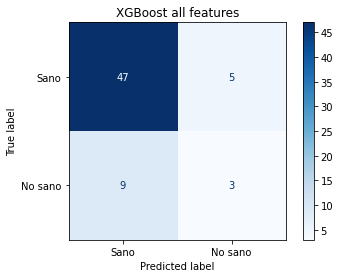

In [43]:
from sklearn.metrics import plot_confusion_matrix

#XGBoost all features
plot_confusion_matrix(xgb_model, x_test_WR, y_test, display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("XGBoost all features")


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'XGBoost 8 features')

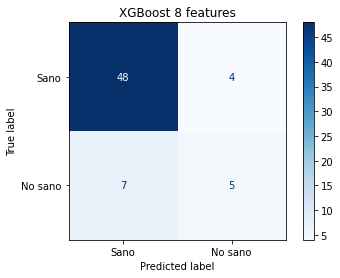

In [44]:
#XGBoost 8 features
plot_confusion_matrix(xgb_FS, X_test_FT_xgb, y_test,display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("XGBoost 8 features")


# 2. Gradient Boosting

In [45]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

## 2.1 Optimización de los hiperparámetros usando RandomizedSearchCV

In [46]:
#Indico que el clasificador que voy a utlizar es GBoosting

gb_model = GradientBoostingClassifier()

In [47]:
params = {
 'n_estimators' : [150,200,250,300,350,400,450,500],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [20,25,30,35,40,45],
}

In [48]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_2 = RandomizedSearchCV(gb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)

r_s_model_2.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [20, 25, 30, 35, 40, 45],
                                        'n_estimators': [150, 200, 250, 300,
                                                         350, 400, 450, 500]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [49]:
r_s_model_2.best_estimator_

GradientBoostingClassifier(learning_rate=0.15, max_depth=35, n_estimators=500)

In [50]:
params = {
 'n_estimators' : [335,340,345,350,355,360,365],
 'learning_rate' : [0.14,0.16,0.18,0.20,0.22,0.24,0.26],
 'max_depth' : [26,27,28,29,30,31,32,33,34],
}

In [51]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_2 = RandomizedSearchCV(gb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)

r_s_model_2.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.14, 0.16, 0.18, 0.2,
                                                          0.22, 0.24, 0.26],
                                        'max_depth': [26, 27, 28, 29, 30, 31,
                                                      32, 33, 34],
                                        'n_estimators': [335, 340, 345, 350,
                                                         355, 360, 365]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [52]:
r_s_model_2.best_estimator_

GradientBoostingClassifier(learning_rate=0.26, max_depth=27, n_estimators=355)

## 2.2 Rendimiento con todas las features

In [53]:
#Construyendo el modelo final
gb_model = GradientBoostingClassifier(learning_rate=0.16, max_depth=26, n_estimators=355)

In [54]:
#Métricas

gb_model.fit(x_train_1, y_train_1)

y_pred = gb_model.predict(x_test_WR)

acc_gb = accuracy_score(y_test, y_pred)
sensibilidad_gb = recall_score(y_test, y_pred)
#precision_xgb = precision_score(y_test, y_pred)
specificity_gb = confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1])
auc_gb = roc_auc_score(y_test, y_pred)

Tabla_2 = pd.DataFrame({ "Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                      "GBoost" : [acc_gb, sensibilidad_gb, specificity_gb, auc_gb]})

Tabla_2

,Prestaciones en test,GBoost
0,Accuracy,0.671875
1,Sensibility,0.166667
2,Specificity,0.788462
3,AUC ROC,0.477564


## 2.3 Selección de características (FS)

1.0


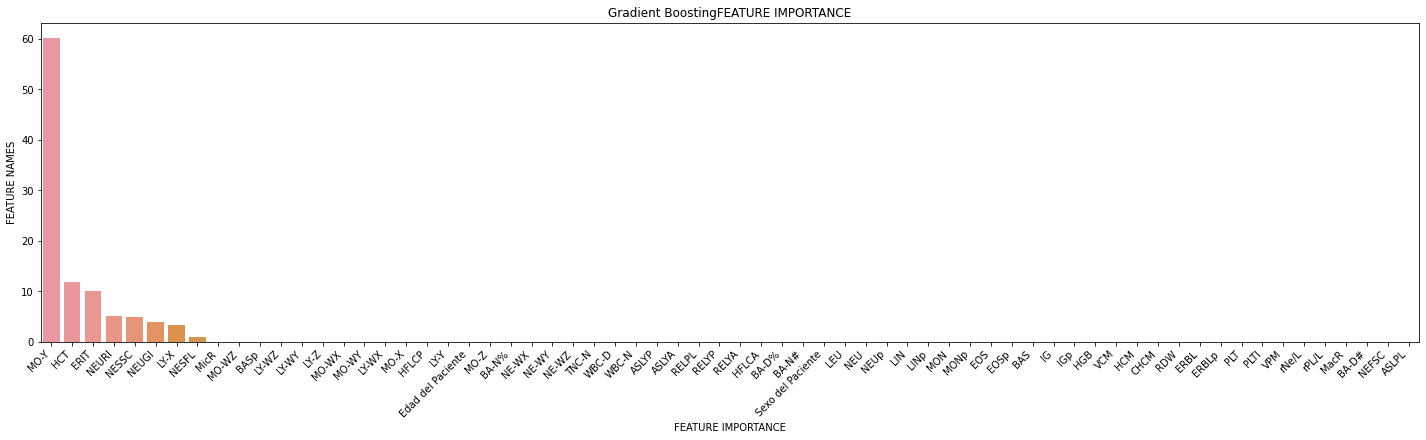

In [55]:
import seaborn as sns
#Plot feature importance
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  fig = plt.figure(figsize=(20,6))
  #Plot Searborn bar chart
  sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  plt.tight_layout()
  fig.autofmt_xdate(rotation=45)


plot_feature_importance(gb_model.feature_importances_*100,x_train_1.columns,'Gradient Boosting')

print(np.sum(gb_model.feature_importances_))

A partir de este gráfico se puede observar la importancia de cada característica haciendo uso de XGBoost. Así pues, MO-Y es la variable que aporta mayor información al realizar la tarea de clasificación, con lo que permitirá, en mayor medida, diferenciar un paciente sano de uno no sano. No obstante, la siguiente variable UCI también presentan información relevante para la predicción.

**Selección de las características en base a la importancia de éstas**

In [56]:
"""
#SelectFromModel

scores_cv = []
thresholds = np.sort(gb_model.feature_importances_) # obtiene la importancia de cada característica
i = 0
for thresh in thresholds:
    print("{} de {}".format(i,len(thresholds)))
    selection = SelectFromModel(gb_model, threshold=thresh, prefit=True)
    select_x_train_1 = selection.transform(x_train_1)
    # train model
    selection_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=25, n_estimators=350)
    #cv estimation
    sc =cross_val_score(selection_model, select_x_train_1, y_train_1, cv=10, scoring='roc_auc',n_jobs=-1)
    scores_cv.append(sc)
    i+=1
  
"""

'\n#SelectFromModel\n\nscores_cv = []\nthresholds = np.sort(gb_model.feature_importances_) # obtiene la importancia de cada característica\ni = 0\nfor thresh in thresholds:\n    print("{} de {}".format(i,len(thresholds)))\n    selection = SelectFromModel(gb_model, threshold=thresh, prefit=True)\n    select_x_train_1 = selection.transform(x_train_1)\n    # train model\n    selection_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=25, n_estimators=350)\n    #cv estimation\n    sc =cross_val_score(selection_model, select_x_train_1, y_train_1, cv=10, scoring=\'roc_auc\',n_jobs=-1)\n    scores_cv.append(sc)\n    i+=1\n  \n'

In [57]:
"""

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize = (80,20))
sc_cv = np.asarray(scores_cv)
scores_m = np.mean(sc_cv,axis = 1)
scores_std = np.std(sc_cv,axis = 1)
xx = np.arange(len(scores_m))
plt.plot(xx,scores_m,'o-')
plt.grid()
_ = plt.xticks(xx,labels= np.arange(1,len(scores_m)+1))
plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')

"""

"\n\nplt.rc('xtick',labelsize=15)\nplt.rc('ytick',labelsize=15)\nplt.figure(figsize = (80,20))\nsc_cv = np.asarray(scores_cv)\nscores_m = np.mean(sc_cv,axis = 1)\nscores_std = np.std(sc_cv,axis = 1)\nxx = np.arange(len(scores_m))\nplt.plot(xx,scores_m,'o-')\nplt.grid()\n_ = plt.xticks(xx,labels= np.arange(1,len(scores_m)+1))\nplt.xlabel('Number of features removed')\nplt.ylabel('Accuracy')\n\n"

Esta gráfica muestra el ***accuracy*** que se alcanza cuando se escogen X características. Desde la izquierda hacia la derecha se van quitando variables consecutivamente, y se puede observar que la predicción del modelo no se degrada hasta llegar a 69 variables. Es decir, solo quedándonos con 2  variables, el modelo es capaz de tener el mismo desempeño en predicción que utilizando todas las variables. Estas característica son las 2 primeras representadas anteriormente en la gráfica anterior.

Además siempre es preferible tener un modelo menos complejo para que de esta forma pueda haber una mejor generalizacion con la incorporación de datos nuevos.

### Permutation Importance

In [58]:
perm = PermutationImportance(gb_model, random_state=1).fit(x_test_WR, y_test)
eli5.show_weights(perm, feature_names = x_test_WR.columns.tolist())

Weight,Feature
0.0531 ± 0.0643,MO-Y
0.0063 ± 0.0153,HCT
0 ± 0.0000,MacR
0 ± 0.0000,rPL/L
0 ± 0.0000,rNe/L
0 ± 0.0000,VPM
0 ± 0.0000,PLTI
0 ± 0.0000,PLT
0 ± 0.0000,ERBLp
0 ± 0.0000,ERBL


## 2.4 Rendimiento con FS en el conjunto de test

In [59]:
"""
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

#convert into a dataframe with sorted feature importances
fi = rf_feat_importance(gb_model,x_train_1)

#select the features
selected_features_RF = fi[:len(fi)-69]['cols'].to_list()
print("Numero de variables seleccionadas Pars:",len(selected_features_RF))
print("Selected features:",selected_features_RF)


X_train_FT_gb = x_train_1[selected_features_RF]
X_test_FT_gb = x_test_WR[selected_features_RF]
"""

'\ndef rf_feat_importance(m, df):\n    return pd.DataFrame({\'cols\':df.columns, \'imp\':m.feature_importances_}\n                       ).sort_values(\'imp\', ascending=False)\n\n#convert into a dataframe with sorted feature importances\nfi = rf_feat_importance(gb_model,x_train_1)\n\n#select the features\nselected_features_RF = fi[:len(fi)-69][\'cols\'].to_list()\nprint("Numero de variables seleccionadas Pars:",len(selected_features_RF))\nprint("Selected features:",selected_features_RF)\n\n\nX_train_FT_gb = x_train_1[selected_features_RF]\nX_test_FT_gb = x_test_WR[selected_features_RF]\n'

Selecciono las características del método permutation importance haciendo uso de .loc

In [60]:
X_train_FT_gb = x_train_1.loc[:,['MO-Y', 'NEUGI', 'NESSC']]
X_test_FT_gb = x_test_WR.loc[:,['MO-Y', 'NEUGI', 'NESSC']]

In [61]:
gb_FS = GradientBoostingClassifier(learning_rate=0.16, max_depth=26, n_estimators=355)
gb_FS.fit(X_train_FT_gb, y_train_1)

GradientBoostingClassifier(learning_rate=0.16, max_depth=26, n_estimators=355)

In [62]:
from sklearn.metrics import roc_auc_score

#Todas las características
y_pred_tot = gb_model.predict(x_test_WR)
acc_tot = accuracy_score(y_test, y_pred_tot)
sensibilidad_tot = recall_score(y_test, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_test, y_pred_tot)[0][0]/(confusion_matrix(y_test, y_pred_tot)[0][0]+confusion_matrix(y_test, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_test, y_pred_tot)


#3 características 
y_pred_3 = gb_FS.predict(X_test_FT_gb)
acc_3 = accuracy_score(y_test, y_pred_3)
sensibilidad_3 = recall_score(y_test, y_pred_3)
#precision_3 = precision_score(y_test, y_pred_3)
specificity_3 = confusion_matrix(y_test, y_pred_3)[0][0]/(confusion_matrix(y_test, y_pred_3)[0][0]+confusion_matrix(y_test, y_pred_3)[0][1])
auc_3 = roc_auc_score(y_test, y_pred_3)

Tabla_gb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                         "GBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot], 
                      "GBoost 3 features " : [acc_3, sensibilidad_3, specificity_3, auc_3]})
Tabla_gb

,Prestaciones en test,GBoost total,GBoost 3 features
0,Accuracy,0.671875,0.687500
1,Sensibility,0.166667,0.333333
2,Specificity,0.788462,0.769231
3,AUC ROC,0.477564,0.551282


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'GBoost all features')

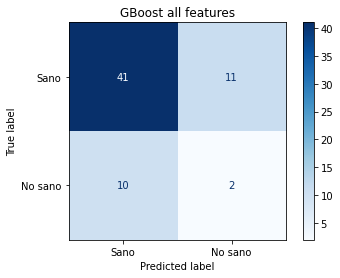

In [63]:
#GBoost all features
plot_confusion_matrix(gb_model, x_test_WR, y_test,display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("GBoost all features")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'GBoost 2 features')

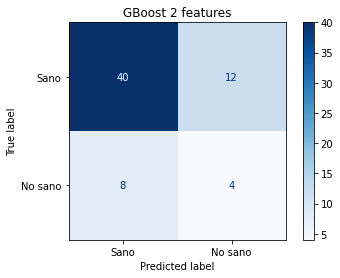

In [64]:
#GBoost 2 features
plot_confusion_matrix(gb_FS, X_test_FT_gb, y_test,display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("GBoost 2 features")

# 3. Histogram-based Gradient Boosting Classifier

In [65]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris

## 3.1 Optimización de los hiperparámetros usando RandomizedSearchCV

In [66]:
#Indico que el clasificador que voy a utlizar es XGBosst

hb_model = HistGradientBoostingClassifier()

In [67]:
params = {
 'max_leaf_nodes': [1,3,5,7,10,13,15,20,25,30,35,40],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [3,4,5,6,8,10,12,15,20,25,30],
}

In [68]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_3 = RandomizedSearchCV(hb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_3.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 524, in fit
    n_threads=n_threads,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_hist_gradient_boosting/grower.py", line 214, in __init__
    min_hessian_to_split,
  File "/usr/local/

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12, 15,
                                                      20, 25, 30],
                                        'max_leaf_nodes': [1, 3, 5, 7, 10, 13,
                                                           15, 20, 25, 30, 35,
                                                           40]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [69]:
r_s_model_3.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.2, max_depth=30,
                               max_leaf_nodes=40)

In [70]:
params = {
 'max_leaf_nodes': [22,23,24,25,26,27,28],
 'learning_rate' : [0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30],
 'max_depth' : [4,5,6,7,8,9,10,11,12],
}

In [71]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_3 = RandomizedSearchCV(hb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_3.fit(x_train_1, y_train_1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.2, 0.21, 0.22, 0.23,
                                                          0.24, 0.25, 0.26,
                                                          0.27, 0.28, 0.29,
                                                          0.3],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12],
                                        'max_leaf_nodes': [22, 23, 24, 25, 26,
                                                           27, 28]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [72]:
r_s_model_3.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.29, max_depth=6,
                               max_leaf_nodes=25)

## 3.2 Rendimiento con todas las features

In [73]:
#Construyendo el modelo final
hb_model = HistGradientBoostingClassifier(learning_rate=0.29, max_depth=6,
                               max_leaf_nodes=25)

In [74]:
#Métricas

hb_model.fit(x_train_1, y_train_1)

y_pred = hb_model.predict(x_test_WR)

acc_hb = accuracy_score(y_test, y_pred)
sensibilidad_hb = recall_score(y_test, y_pred)
#precision_xgb = precision_score(y_test, y_pred)
specificity_hb = confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1])
auc_hb = roc_auc_score(y_test, y_pred)

Tabla_3 = pd.DataFrame({ "Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                      "HBoost" : [acc_hb, sensibilidad_hb, specificity_hb, auc_hb]})

Tabla_3

,Prestaciones en test,HBoost
0,Accuracy,0.796875
1,Sensibility,0.333333
2,Specificity,0.903846
3,AUC ROC,0.618590


## 3.3 Selección de características (FS)

In [75]:
"""
import seaborn as sns
#Plot feature importance
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  fig = plt.figure(figsize=(20,6))
  #Plot Searborn bar chart
  sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  plt.tight_layout()
  fig.autofmt_xdate(rotation=45)


plot_feature_importance(hb_model.feature_importances_*100,x_train_1.columns,'Histogram-based')

print(np.sum(hb_model.feature_importances_))

"""

"\nimport seaborn as sns\n#Plot feature importance\ndef plot_feature_importance(importance,names,model_type):\n\n  #Create arrays from feature importance and feature names\n  feature_importance = np.array(importance)\n  feature_names = np.array(names)\n\n  #Create a DataFrame using a Dictionary\n  data={'feature_names':feature_names,'feature_importance':feature_importance}\n  fi_df = pd.DataFrame(data)\n\n  #Sort the DataFrame in order decreasing feature importance\n  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)\n\n  #Define size of bar plot\n  fig = plt.figure(figsize=(20,6))\n  #Plot Searborn bar chart\n  sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])\n  #Add chart labels\n  plt.title(model_type + 'FEATURE IMPORTANCE')\n  plt.xlabel('FEATURE IMPORTANCE')\n  plt.ylabel('FEATURE NAMES')\n  plt.tight_layout()\n  fig.autofmt_xdate(rotation=45)\n\n\nplot_feature_importance(hb_model.feature_importances_*100,x_train_1.columns,'Histogram-ba

### Permutation Importance

Selecciono las características del método permutation importance haciendo uso de .loc

In [76]:
perm = PermutationImportance(hb_model, random_state=1).fit(x_test_WR, y_test)
eli5.show_weights(perm, feature_names = x_test_WR.columns.tolist())

Weight,Feature
0.0594 ± 0.0696,MO-Y
0 ± 0.0000,BA-D%
0 ± 0.0000,Sexo del Paciente
0 ± 0.0000,BA-D#
0 ± 0.0000,MacR
0 ± 0.0000,rPL/L
0 ± 0.0000,VPM
0 ± 0.0000,PLTI
0 ± 0.0000,PLT
0 ± 0.0000,NEUp


## 3.4 Rendimiento con FS en el conjunto de test

In [77]:
X_train_FT_hb = x_train_1.loc[:,['MO-Y']]
X_test_FT_hb = x_test_WR.loc[:,['MO-Y']]

In [78]:
hb_FS = HistGradientBoostingClassifier(learning_rate=0.29, max_depth=6, max_leaf_nodes=25)
hb_FS.fit(X_train_FT_hb, y_train_1)

HistGradientBoostingClassifier(learning_rate=0.29, max_depth=6,
                               max_leaf_nodes=25)

In [79]:
from sklearn.metrics import roc_auc_score

#Todas las características
y_pred_tot = hb_model.predict(x_test_WR)
acc_tot = accuracy_score(y_test, y_pred_tot)
sensibilidad_tot = recall_score(y_test, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_test, y_pred_tot)[0][0]/(confusion_matrix(y_test, y_pred_tot)[0][0]+confusion_matrix(y_test, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_test, y_pred_tot)


#1 características 
y_pred_1 = hb_FS.predict(X_test_FT_hb)
acc_1 = accuracy_score(y_test, y_pred_1)
sensibilidad_1 = recall_score(y_test, y_pred_1)
#precision_2 = precision_score(y_test, y_pred_2)
specificity_1 = confusion_matrix(y_test, y_pred_1)[0][0]/(confusion_matrix(y_test, y_pred_1)[0][0]+confusion_matrix(y_test, y_pred_1)[0][1])
auc_1 = roc_auc_score(y_test, y_pred_1)

Tabla_hb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                         "HBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot], 
                      "HBoost 1 features " : [acc_1, sensibilidad_1, specificity_1, auc_1]})
Tabla_hb

,Prestaciones en test,HBoost total,HBoost 1 features
0,Accuracy,0.796875,0.703125
1,Sensibility,0.333333,0.500000
2,Specificity,0.903846,0.750000
3,AUC ROC,0.618590,0.625000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'HBoost all features')

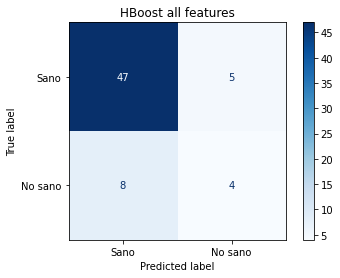

In [80]:
#GBoost all features
plot_confusion_matrix(hb_model, x_test_WR, y_test,display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("HBoost all features")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'HBoost 2 features')

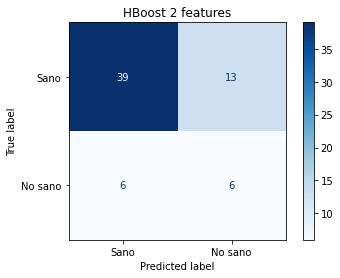

In [81]:
#GBoost 2 features
plot_confusion_matrix(hb_FS, X_test_FT_hb, y_test,display_labels=["Sano","No sano"],
                                 cmap=plt.cm.Blues)
plt.title("HBoost 2 features")

# 4. Machine learning añadiendo información sobre la tendencia temporal

## 4.1 XGBoost

Tengo que añadir 3 columna nuevas por cada feature. Una columna con el primer coeficiente (se repite ese mismo coeficiente para todos los pacientes, es decir una columna entera con el mismo número). Y así con los otros 2 coeficientes

In [84]:
X_train_FT_xgb.head() 

,MicR,LINp,HGB,HCM,NEUp,HFLCA,RELPL,ERIT,IGp
1,0.70,34.40,10.40,33.50,49.00,0.03,17.1,3.100,0.30
5,6.70,34.40,12.10,27.30,38.50,0.01,7.6,4.440,0.30
16,1.92,37.26,13.54,29.74,53.06,0.02,8.6,4.546,0.66
19,2.20,5.70,15.70,29.50,87.90,0.02,11.2,5.320,0.80
22,2.00,12.50,11.96,31.90,72.90,0.01,23.0,4.008,0.78


In [86]:
X_train_FT_xgb.assign(B_MicR=6)

,MicR,LINp,HGB,HCM,NEUp,HFLCA,RELPL,ERIT,IGp,B_MicR
1,0.70,34.40,10.40,33.50,49.00,0.030,17.10,3.100,0.30,6
5,6.70,34.40,12.10,27.30,38.50,0.010,7.60,4.440,0.30,6
16,1.92,37.26,13.54,29.74,53.06,0.020,8.60,4.546,0.66,6
19,2.20,5.70,15.70,29.50,87.90,0.020,11.20,5.320,0.80,6
22,2.00,12.50,11.96,31.90,72.90,0.010,23.00,4.008,0.78,6
...,...,...,...,...,...,...,...,...,...,...
243,0.50,3.90,11.60,32.40,92.20,0.050,14.80,3.580,0.80,6
249,2.24,13.90,14.26,30.12,70.76,0.040,11.48,4.730,0.80,6
252,3.70,14.42,13.78,29.34,74.16,0.018,14.00,4.626,1.32,6
254,1.60,11.20,12.70,30.10,83.80,0.060,14.70,4.220,0.40,6
